# Unsupervised anomaly detection with Temporian and scikit-learn

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/temporian/blob/last-release/docs/src/tutorials/anomaly_detection_unsupervised.ipynb)

In this tutorial we'll be using Temporian to perform exploratory data analysis and feature engineering on the ServerMachineDataset (SMD), published as part of the [OmniAnomaly](https://github.com/NetManAIOps/OmniAnomaly/) paper, to then train a simple [IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest.predict) model on it in an unsupervised fashion to detect anomalies.

The ServerMachineDataset (hosted as csv files in that same repository) is a 5-week-long dataset collected from a large internet company. It is made up of system metrics (such as CPU utilization, network in and out, memory usage, etc.) from 28 different machines belonging to 3 groups.

The data has been anonymized and normalized, so there's no telling what feature means what, and it's also had its timestamps removed, so we will need to treat it as a normal time series, since we know the values are sequential, but don't know how much time has passed between each one. This makes us lose out on some of Temporian's potential - but perfectly illustrates that Temporian can be used on time series data too!

## Installation and imports

In [466]:
%pip install temporian -q


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [467]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight

import temporian as tp

## Downloading the dataset

The dataset is comprised of 3 groups of 8, 9, and 11 machines respectively, with names `"machine-1-1"`, ..., `"machine-3-11"`.

Let's create the list of names, and then download each machine's data and labels to a `tmp/temporian_server_machine_dataset/` folder.

For the sake of time we'll only be using 3 machines' data, but we encourage you to try it out in the complete dataset by swapping the commented line with the following one in the cell below.

In [468]:
# Create list of machine names

# machines_per_group = [8, 9, 11]
machines_per_group = [2, 1, 0]

machines = [f"machine-{group}-{id}" for group, machine in zip(range(1, 4), machines_per_group) for id in range(1, machine + 1)]

machines

['machine-1-1', 'machine-1-2', 'machine-2-1']

In [469]:
data_dir = Path("tmp/temporian_server_machine_dataset")

data_dir.mkdir(parents=True, exist_ok=True)

DATA = "data.csv"
LABELS = "labels.csv"

# Download the data and labels for each machine to its own folder
for machine in machines:
    print(f"Downloading data and labels for {machine}")
    
    dir = data_dir / machine
    dir.mkdir(exist_ok=True)
    
    data_path = dir / DATA
    if not data_path.exists():
        os.system(f"wget -q -O {data_path} https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test/{machine}.txt")

    labels_path = dir / LABELS
    if not labels_path.exists():
        os.system(f"wget -q -O {labels_path} https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test_label/{machine}.txt")

## Loading the data

We'll use pandas to load the data and perform some basic manipulation of it before transforming it into a Temporian `EventSet`.

Note that in the code below, we'll be using the loaded data's pandas index (which is a sequential one) as the `"timestamp"` column for each DataFrame. This will effectively render a time series, since each new event will be one unit of time ahead of the previous one, but it means that the timestamp column has no actual semantic meaning.

In [470]:
dfs = []

for machine in machines:
    dir = data_dir / machine

    # Read the data and labels
    df = pd.read_csv(dir / DATA, header=None).add_prefix("f")
    labels = pd.read_csv(dir/ LABELS, header=None)
    df = df.assign(label=labels)

    # Assign the machine as a feature
    df["machine"] = machine
    
    # Use index as timestamps column
    df = df.reset_index(drop=False, names="timestamp")

    # Cast column names to string
    df.columns = df.columns.astype(str)

    print(f"Events in {machine}: {len(df)}")
    dfs.append(df)

df = pd.concat(dfs)
df

Events in machine-1-1: 28479
Events in machine-1-2: 23694
Events in machine-2-1: 23694


,timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f30,f31,f32,f33,f34,f35,f36,f37,label,machine
0,0,0.075269,0.065678,0.070234,0.074332,0.000000,0.933333,0.274011,0.0,0.031081,...,0.068036,0.048893,0.000386,0.000034,0.064432,0.064500,0.0,0.0,0,machine-1-1
1,1,0.086022,0.080508,0.075808,0.076655,0.000000,0.930769,0.274953,0.0,0.031081,...,0.070020,0.050437,0.000386,0.000022,0.065228,0.065224,0.0,0.0,0,machine-1-1
2,2,0.075269,0.064619,0.071349,0.074332,0.000000,0.928205,0.274953,0.0,0.030940,...,0.069684,0.055069,0.000386,0.000045,0.067111,0.067178,0.0,0.0,0,machine-1-1
3,3,0.086022,0.048729,0.063545,0.070848,0.000000,0.928205,0.273070,0.0,0.027250,...,0.073253,0.051467,0.000000,0.000034,0.066676,0.066744,0.0,0.0,0,machine-1-1
4,4,0.086022,0.051907,0.062430,0.070848,0.000000,0.933333,0.274011,0.0,0.030940,...,0.070932,0.051467,0.000386,0.000022,0.066604,0.066671,0.0,0.0,0,machine-1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23689,23689,0.090909,0.006322,0.016376,0.043413,0.684211,0.346941,0.326509,0.0,0.000000,...,0.108795,0.128205,0.000000,0.005076,0.110849,0.116331,0.0,0.0,0,machine-2-1
23690,23690,0.121212,0.005501,0.014843,0.041364,0.684211,0.340833,0.320502,0.0,0.000268,...,0.088135,0.102564,0.000000,0.040609,0.077830,0.082774,0.0,0.0,0,machine-2-1
23691,23691,0.141414,0.012275,0.017586,0.042854,0.684211,0.343306,0.322957,0.0,0.000000,...,0.150872,0.153846,0.000000,0.005076,0.115566,0.123043,0.0,0.0,0,machine-2-1
23692,23692,0.070707,0.007718,0.015812,0.040991,0.684211,0.250723,0.222559,0.0,0.000000,...,0.083017,0.102564,0.000000,0.005076,0.082547,0.085011,0.0,0.0,0,machine-2-1


In [471]:
df.describe()

,timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f29,f30,f31,f32,f33,f34,f35,f36,f37,label
count,75867.000000,75867.000000,75867.000000,75867.000000,75867.000000,75867.000000,75867.000000,75867.000000,75867.0,75867.000000,...,75867.000000,75867.000000,75867.000000,75867.000000,75867.000000,75867.000000,75867.000000,75867.0,75867.0,75867.000000
mean,12744.598086,0.157383,0.073493,0.082287,0.095368,0.272900,0.772198,0.285371,0.0,0.009690,...,0.016043,0.103234,0.091864,0.047127,0.026619,0.093825,0.096704,0.0,0.0,0.058075
std,7479.042159,0.132033,0.089300,0.089185,0.087559,0.265939,0.178747,0.121738,0.0,0.019412,...,0.022095,0.106289,0.104211,0.098845,0.038077,0.110105,0.112472,0.0,0.0,0.233887
min,0.000000,0.000000,0.000000,0.000242,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,6322.000000,0.064516,0.017161,0.027871,0.041524,0.000000,0.645669,0.215990,0.0,0.000000,...,0.000000,0.031262,0.000000,0.000000,0.000034,0.000000,0.000000,0.0,0.0,0.000000
50%,12644.000000,0.118280,0.043148,0.055741,0.076952,0.157895,0.849924,0.274953,0.0,0.000805,...,0.017192,0.066643,0.056613,0.000000,0.005076,0.063129,0.064934,0.0,0.0,0.000000
75%,18966.000000,0.222222,0.103784,0.108138,0.124278,0.575472,0.907551,0.355932,0.0,0.018024,...,0.020833,0.143290,0.153846,0.000386,0.048611,0.141509,0.147314,0.0,0.0,0.000000
max,28478.000000,1.000000,1.000000,1.000000,1.000000,0.783019,1.000000,1.000000,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000


Awesome! Seems like we have 75867 rows and 41 columns in our dataset, made up of:
- 38 metric columns, which will be the main features we'll be working on with Temporian
- 1 categorical column, which will allow us to tell apart events that belong to different machines
- 1 timestamps column
- 1 labels column

As stated previously, all metrics seem to be anonymized and normalized to [0, 1], so we won't need to take care of that ourselves.

## Creating an EventSet

Now that our data's ready, let's create a Temporian `EventSet` from it.

We'll use the `"machine"` column as its index, which means that Temporian will treat the events corresponding to each machine as an independent time series when computing features off of it. This is clear when displaying the `EventSet`, which renders one table for each of our indexes' values.

Note that, since we used one column as timestamps and two others as indexes, our `EventSet` has 38 features instead of the previous 42.

In [472]:
tp.config.max_display_features = 100
tp.config.max_display_events = 5

evset = tp.from_pandas(df, indexes=["machine"])

evset

timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,label
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07415,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,0
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01473,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.09459,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,0,0,0.1274,0.09449,0.09817,0.07752,0.9422,0.0184,0.03411,0.01696,0,0.08093,0,0.008596,0.07093,0.05147,0.000386,2.2e-05,0.0666,0.06667,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,label
0,0.23,0.1095,0.1266,0.1338,0.2264,0.621,0.4093,0,9.3e-05,1.5e-05,0,0.00722,0,0.03696,0.003551,0.02929,0,0,0.002313,0.0108,0.005868,0.04877,0.07143,0.08159,0.2,0.07692,0,0.01994,0,0,0.04801,0,0,0.0625,0,0,0,0,0
1,0.25,0.1089,0.1271,0.134,0.2264,0.5473,0.337,0,9.3e-05,1.5e-05,0,0.009025,0,0.03926,0.004129,0.03305,0,0,0.01261,0.02618,0.01733,0.0752,0.1071,0.159,0.2,0.1538,0,0.03768,0,0,0.07518,0,0,0.05556,0,0.5,0,0,0
2,0.24,0.1228,0.1308,0.1353,0.2264,0.4784,0.2648,0,0.000653,0.000134,8e-06,0.01805,0,0.09858,0.009166,0.09242,0,0,0.1534,0.02637,0.1565,0.2137,0,0.159,0.2,0.1581,0,0.1788,0,0,0.2129,0,0,0.06944,0,0,0,0,0


Let's free up some memory by deleting the pandas DataFrame and casting all of our features to float32 (which will also make Temporian create new float32 features when applying operators on the original ones) and our label to int32.

In [473]:
del df

In [474]:
evset = evset.cast(tp.float32).cast({"label": tp.int32})
evset.schema.features

[('f0', float32),
 ('f1', float32),
 ('f2', float32),
 ('f3', float32),
 ('f4', float32),
 ('f5', float32),
 ('f6', float32),
 ('f7', float32),
 ('f8', float32),
 ('f9', float32),
 ('f10', float32),
 ('f11', float32),
 ('f12', float32),
 ('f13', float32),
 ('f14', float32),
 ('f15', float32),
 ('f16', float32),
 ('f17', float32),
 ('f18', float32),
 ('f19', float32),
 ('f20', float32),
 ('f21', float32),
 ('f22', float32),
 ('f23', float32),
 ('f24', float32),
 ('f25', float32),
 ('f26', float32),
 ('f27', float32),
 ('f28', float32),
 ('f29', float32),
 ('f30', float32),
 ('f31', float32),
 ('f32', float32),
 ('f33', float32),
 ('f34', float32),
 ('f35', float32),
 ('f36', float32),
 ('f37', float32),
 ('label', int32)]

## Data visualization

Let's take a look at some of the first machine's features.

The number of plots (39) is larger than "options.max_num_plots=20". Only the first plots will be printed.
The number of plots (3) is larger than "options.max_num_plots=1". Only the first plots will be printed.


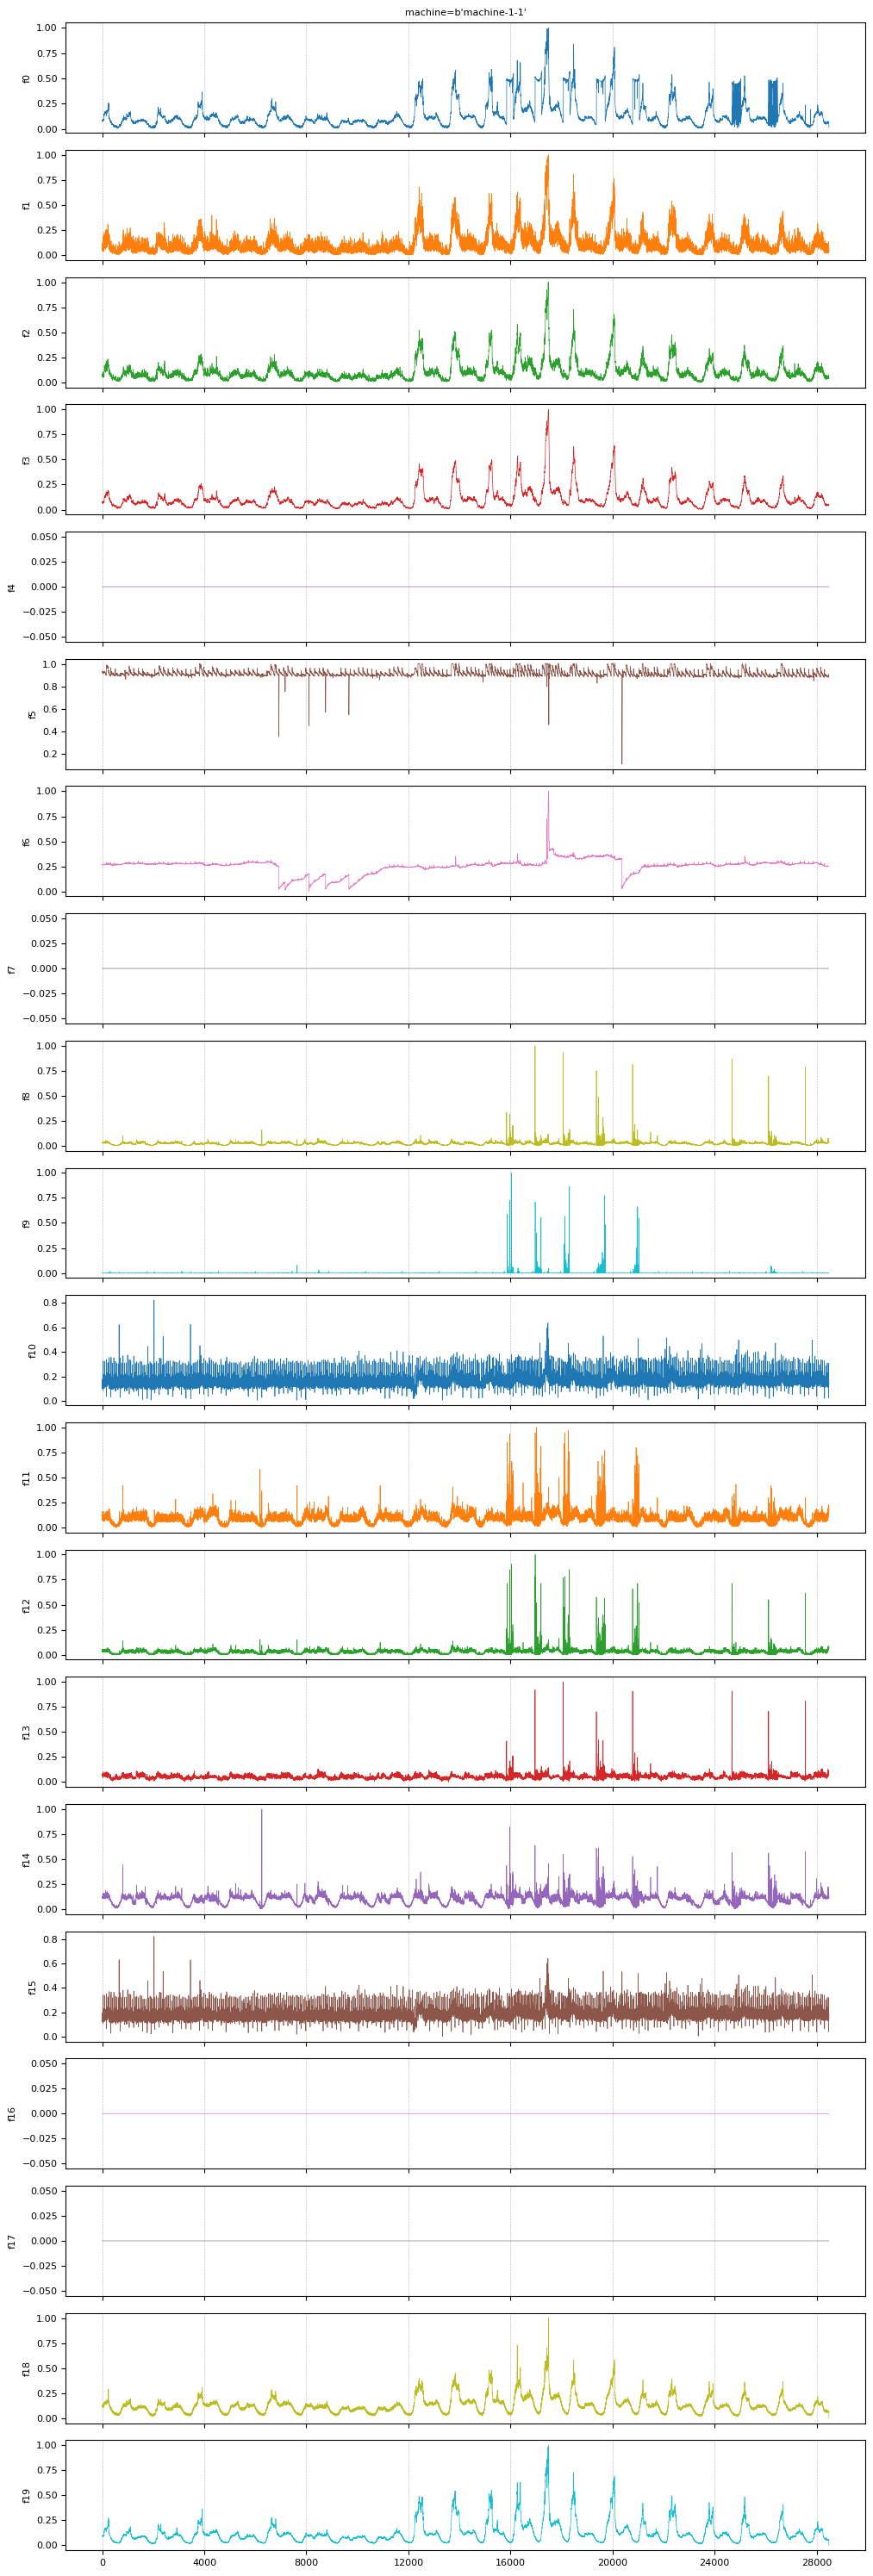

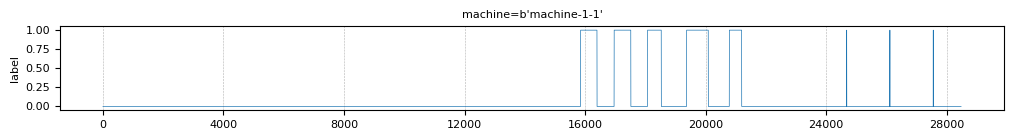

In [475]:
evset.plot(indexes="machine-1-1")
evset[["label"]].plot(max_num_plots=1)

Great! A lot to unpack here:
- It seems to be easy to understand when an anomaly occurs (label takes value of 1) by looking at the other plots. Features 11 to 14, for example, seem to be very correlated to the label.
- The data seems to have some periodicity to it.
- Some features seem empty, and we could evaluate dropping them if needed.

## Data preparation

To prepare our data to train a model on it, let's start off by separating the features from the labels.

In [476]:
feature_names = evset.schema.feature_names()
feature_names.remove("label")

raw_features = evset[feature_names]
labels = evset[["label"]]

print("Raw features:", raw_features.schema)
print("Labels:", labels.schema)

Raw features: features: [('f0', float32), ('f1', float32), ('f2', float32), ('f3', float32), ('f4', float32), ('f5', float32), ('f6', float32), ('f7', float32), ('f8', float32), ('f9', float32), ('f10', float32), ('f11', float32), ('f12', float32), ('f13', float32), ('f14', float32), ('f15', float32), ('f16', float32), ('f17', float32), ('f18', float32), ('f19', float32), ('f20', float32), ('f21', float32), ('f22', float32), ('f23', float32), ('f24', float32), ('f25', float32), ('f26', float32), ('f27', float32), ('f28', float32), ('f29', float32), ('f30', float32), ('f31', float32), ('f32', float32), ('f33', float32), ('f34', float32), ('f35', float32), ('f36', float32), ('f37', float32)]
indexes: [('machine', str_)]
is_unix_timestamp: False

Labels: features: [('label', int32)]
indexes: [('machine', str_)]
is_unix_timestamp: False



Next, we'll need to split our dataset into train and testing sets, which we'll use an 80/20 split for.

Note that the train labels will only be used for evaluation purposes.

We'll be creating reusable functions for each step, since we'll do some iteration over the `feature engineering -> training -> evaluation` cycle.

In [477]:
CATEGORICAL_COLS = ["machine"]
DROP_COLS = CATEGORICAL_COLS + ["timestamp"]

def make_datasets(X: tp.EventSet, y: tp.EventSet, encode_categoricals: bool = True):
    """Splits X and y into train and test sets and transforms categorical features into one-hot-encoded features."""

    # Compute the timestamp that corresponds to 80% of the data, and use it to split the data
    # Note that not all of each machine's time series are of the same length, so the ones with more will have more test examples
    train_cutoff = int(len(X.get_arbitrary_index_data()) * 0.8)
    print("Last train timestamp:", train_cutoff)

    # Compute masks and split data based on cutoff
    timestamp = X.timestamps()
    train_mask = timestamp <= train_cutoff
    test_mask = ~train_mask
    X_train = X.filter(train_mask)
    X_test = X.filter(test_mask)
    y_train = y.filter(train_mask)
    y_test = y.filter(test_mask)

    # Using a DataFrame for these last few steps to feed into the scikit-learn model
    # Note that even though the raw data has no NaNs, we will create some during our feature engineering
    X_train_df = tp.to_pandas(X_train).fillna(-1)
    
    # Replace timestamp and categorical columns with the new encoded ones
    X_train = X_train_df.drop(columns=DROP_COLS).to_numpy()

    # Repeat process for test set
    X_test_df = tp.to_pandas(X_test).fillna(-1)
    X_test = X_test_df.drop(columns=DROP_COLS).to_numpy()

    if encode_categoricals:
        # Define and fit the one-hot encoder for our categorical features
        encoder = OneHotEncoder(sparse_output=False)
        train_encoded = encoder.fit_transform(X_train_df[CATEGORICAL_COLS])
        test_encoded = encoder.transform(X_test_df[CATEGORICAL_COLS])
        X_train = np.concatenate([X_train, train_encoded], axis=1)
        X_test = np.concatenate([X_test, test_encoded], axis=1)

    # Cast our labels and remove timestamp and categorical columns
    y_train = tp.to_pandas(y_train).drop(columns=DROP_COLS).squeeze()
    y_test = tp.to_pandas(y_test).drop(columns=DROP_COLS).squeeze()

    print("Number of samples in train set:", len(X_train))
    print("Number of positive (anomalous) samples in train set:", y_train.sum())
    print("Number of samples in test set:", len(X_test))
    print("Number of positive (anomalous) samples in test set:", y_test.sum())

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = make_datasets(raw_features, labels)

Last train timestamp: 18955
Number of samples in train set: 56868
Number of positive (anomalous) samples in train set: 2702
Number of samples in test set: 18999
Number of positive (anomalous) samples in test set: 1704


Those numbers look alright. However, we seem to be dealing with a fairly unbalanced dataset, with the positive labels in the training set accounting for only 3% of the total. We'll remember to take that into account when evaluating our model.

## Training

Having done all that work to prepare our data, all that remains is to train our model.

In [478]:
contamination = y_train.sum() / len(y_train)
print(f"{contamination=}")

def train(X_train):
    model = IsolationForest(
        n_estimators=200,
        contamination=contamination,
        max_samples=0.2,
        max_features=0.2,
        bootstrap=False,
        n_jobs=-1,
        verbose=1,
        random_state=0,
    )
    model.fit(X_train)
    return model

contamination=0.04751354012801576


In [479]:
model = train(X_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.6s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished


## Evaluation

As we noticed previously, the dataset is very unbalanced. Reporting the accuracy of our model will therefore not give us a good idea of its performance, since false negatives and false positives would contribute equally to the total, but we would much rather have a false positive than a false negative. It also doesn't take into account the model's confidence in each prediction.

Instead of overall accuracy, we'll be measuring mean accuracy, i.e., the average of the accuracy of the model for each class (positive and negative, or anomalous and non-anomalous). This can be easily obtained by weighing each sample inversely-proportionally to how often its class appears in the data.

On top of that, we'll be reporting the model's ROC AUC score, which provides an aggregate measure of performance across all possible classification thresholds (since our model outputs an anomaly score for each sample, and in a real-world scenario it would be up to us to define the thershold from which we consider an event to be marked as anomalous).

In [480]:
# Compute class weights (we only need to do this once, since it won't be changing while we iterate over feature engineering)
classes = y_train.unique()
class_weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))

print("Class weights:", class_weights)

Class weights: {0: 0.5249418454380977, 1: 10.523316062176166}


In [481]:
figsize=(20,3)

results = {}

def evaluate(model, X_train, y_train, X_test, y_test, name):
    """Evaluates a model on its training data and unseen test data, computing accuracy score and plotting ground truth vs predictions."""
    # Compute sample weights based on class weights
    train_sample_weights = compute_sample_weight(class_weights, y_train)
    test_sample_weights = compute_sample_weight(class_weights, y_test)

    # Predict
    train_preds = model.predict(X_train)
    train_preds[train_preds == 1] = 0
    train_preds[train_preds == -1] = 1
    print(train_preds)
    
    test_preds = model.predict(X_test)
    test_preds[test_preds == 1] = 0
    test_preds[test_preds == -1] = 1
    
    # Compute scores
    train_acc = accuracy_score(y_train, train_preds, sample_weight=train_sample_weights)
    test_acc = accuracy_score(y_test, test_preds, sample_weight=test_sample_weights)
    
    train_roc_auc = roc_auc_score(y_train, -model.score_samples(X_train))
    test_roc_auc = roc_auc_score(y_test, -model.score_samples(X_test))
    
    results[name] = {"train_accuracy": train_acc, "test_accuracy": test_acc, "train_roc_auc": train_roc_auc, "test_roc_auc": test_roc_auc}
    print("Results:")
    print(pd.DataFrame(results))

    print("Train and test labels and predictions")
    tp.event_set(timestamps=y_train.index, features={"label": y_train, "pred": train_preds}).plot(style="vline")
    tp.event_set(timestamps=y_test.index, features={"label": y_test, "pred": test_preds}).plot(style="vline")

[0 0 0 ... 0 0 0]
Results:
                raw features
test_accuracy       0.565389
test_roc_auc        0.904260
train_accuracy      0.648161
train_roc_auc       0.846675
Train and test labels and predictions


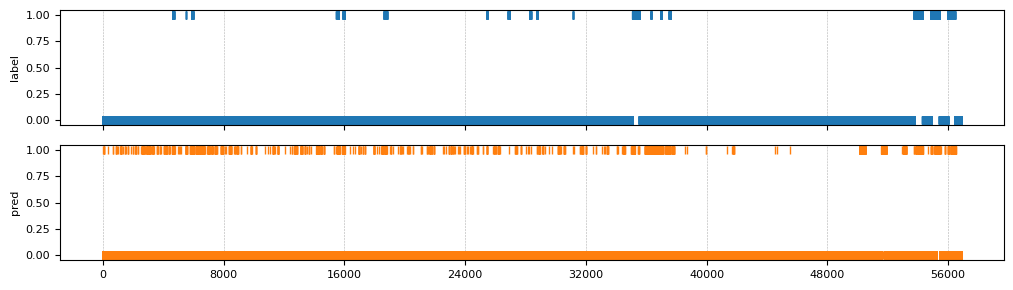

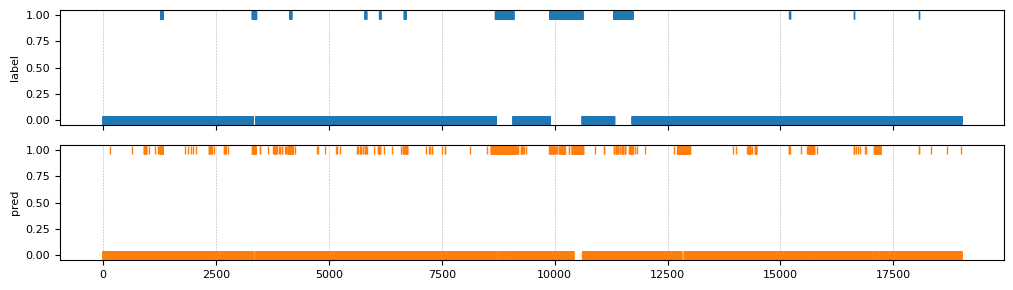

In [482]:
evaluate(model, X_train, y_train, X_test, y_test, "raw features")

That's pretty decent for a first try. Our model seems to be learning, but not overfitting, on its training data. There's plenty of room for improvement though, so let's kick off the feature engineering!

## Feature engineering

### Lag features

Right now our model only has access to each event's raw metric values, + the group and machine that it belongs to. This means that it has no knowledge of the **context** an event is happening on - some values might have been completely normal when the measuring started, but anomalous a couple of weeks later, e.g. if that machine's usage went up as a whole during that time and its baseline usage now stands much higher than it used to.

To combat this, we'll start by lagging the values of each feature. In doing this, we're providing the model (some) information about that the metric's value looked like a couple of steps into the past.

In [483]:
lag_features = []

# Lag each raw feature by 1, 2, ..., 10 steps
for window in range(1, 11):
    lag_features.append(raw_features.lag(window).resample(raw_features).prefix(f"lag_{window}_"))

features = tp.glue(raw_features, *lag_features)
features

timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,lag_1_f0,lag_1_f1,lag_1_f2,lag_1_f3,lag_1_f4,lag_1_f5,lag_1_f6,lag_1_f7,lag_1_f8,lag_1_f9,lag_1_f10,lag_1_f11,lag_1_f12,lag_1_f13,lag_1_f14,lag_1_f15,lag_1_f16,lag_1_f17,lag_1_f18,lag_1_f19,lag_1_f20,lag_1_f21,lag_1_f22,lag_1_f23,lag_1_f24,lag_1_f25,lag_1_f26,lag_1_f27,lag_1_f28,lag_1_f29,lag_1_f30,lag_1_f31,lag_1_f32,lag_1_f33,lag_1_f34,lag_1_f35,lag_1_f36,lag_1_f37,lag_2_f0,lag_2_f1,lag_2_f2,lag_2_f3,lag_2_f4,lag_2_f5,lag_2_f6,lag_2_f7,lag_2_f8,lag_2_f9,lag_2_f10,lag_2_f11,lag_2_f12,lag_2_f13,lag_2_f14,lag_2_f15,lag_2_f16,lag_2_f17,lag_2_f18,lag_2_f19,lag_2_f20,lag_2_f21,lag_2_f22,lag_2_f23,…
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,…
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,…
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,0,0,0.1274,0.09449,0.09817,0.07752,0.9422,0.0184,0.03411,0.01696,0,0.08093,0,0.008596,0.07093,0.05147,0.000386,2.2e-05,0.0666,0.06667,0,0,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,…
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp

Let's take a look at any metric alongside its lagged values. We'll select a small time window, to be able to appreciate how the time series moves to the right as the number of lagged timesteps increases.

The number of plots (33) is larger than "options.max_num_plots=10". Only the first plots will be printed.


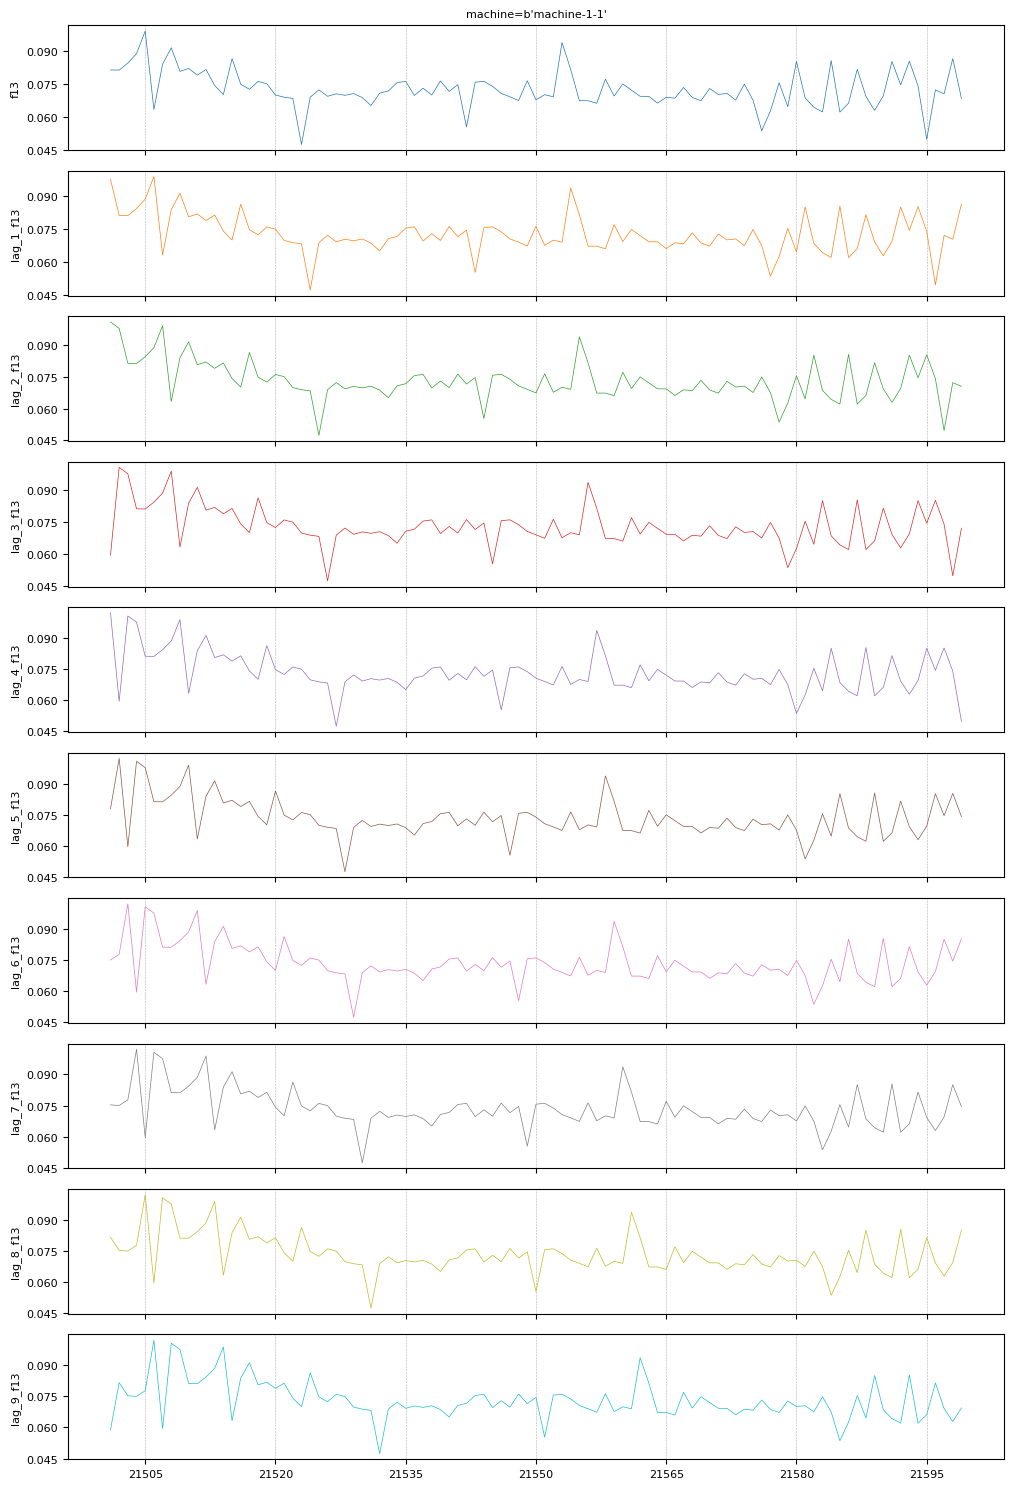

In [484]:
f13_lags = features[["f13"] + [f"lag_{i}_f13" for i in range(1, 11)]]
timestamps = f13_lags.timestamps()
f13_lags = f13_lags.filter((timestamps > 21500) & (timestamps < 21600))
f13_lags.plot(max_num_plots=10)

Time to train and evaluate a new model with these new features! 

Last train timestamp: 18955
Number of samples in train set: 56868
Number of positive (anomalous) samples in train set: 2702
Number of samples in test set: 18999
Number of positive (anomalous) samples in test set: 1704


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.4s remaining:    5.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.5s finished


[1 1 1 ... 0 0 0]
Results:
                raw features  lagged features
train_accuracy      0.648161         0.647772
test_accuracy       0.565389         0.562307
train_roc_auc       0.846675         0.868658
test_roc_auc        0.904260         0.909366
Train and test labels and predictions


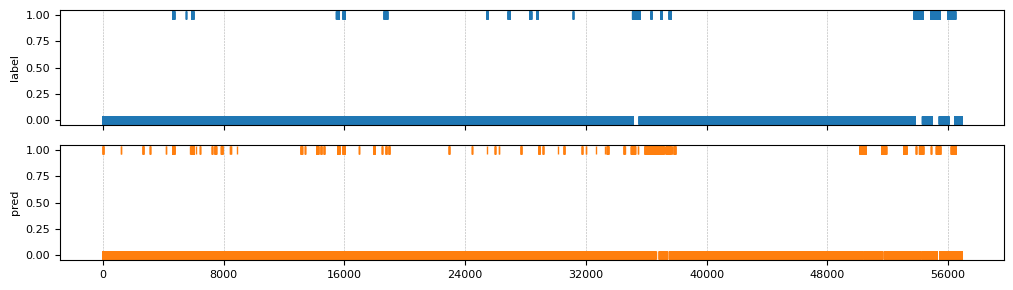

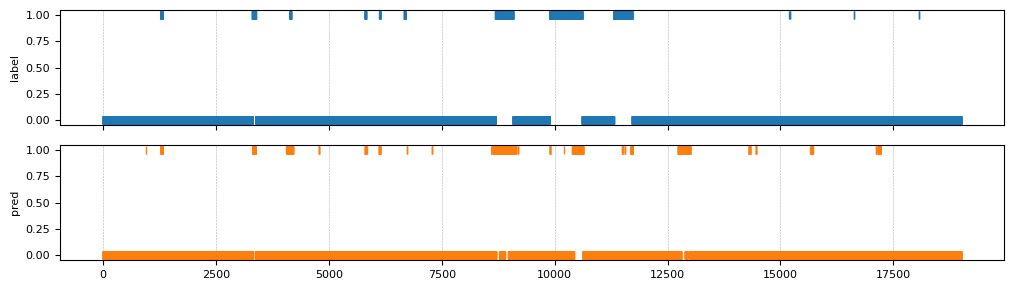

In [485]:
X_train, y_train, X_test, y_test = make_datasets(features, labels)
model = train(X_train)
evaluate(model, X_train, y_train, X_test, y_test, "lagged features")

### Moving statistic features

The lag features helped the model, but not inmensely.

Although useful, the raw lagged values aren't enough to provide the model a comprehensive look at each value's past context. Note also that we only gave it a glimpse of 10 steps into the past, and each time series has more than 24k values.

This is where **moving statistics** can come in handy. Instead of a list of raw values, we can provide the model an aggregation of each metric's values over the last N timesteps. For example, we can tell it what the maximum and minimum value of a metric were in the last steps, of what the standard deviation was in the last 1000. 

Luckily, Temporian's window operators make this a breeze.

In [486]:
moving_statistic_features = []

# Compute the moving average, standard deviation, max, and min over different windows
for window in [20, 200, 2000]:
    moving_statistic_features.append(raw_features.simple_moving_average(window).prefix(f"avg_{window}_"))
    moving_statistic_features.append(raw_features.moving_standard_deviation(window).prefix(f"std_{window}_"))
    moving_statistic_features.append(raw_features.moving_max(window).prefix(f"max_{window}_"))
    moving_statistic_features.append(raw_features.moving_min(window).prefix(f"min_{window}_"))

features = tp.glue(raw_features, *lag_features, *moving_statistic_features)
features

timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,lag_1_f0,lag_1_f1,lag_1_f2,lag_1_f3,lag_1_f4,lag_1_f5,lag_1_f6,lag_1_f7,lag_1_f8,lag_1_f9,lag_1_f10,lag_1_f11,lag_1_f12,lag_1_f13,lag_1_f14,lag_1_f15,lag_1_f16,lag_1_f17,lag_1_f18,lag_1_f19,lag_1_f20,lag_1_f21,lag_1_f22,lag_1_f23,lag_1_f24,lag_1_f25,lag_1_f26,lag_1_f27,lag_1_f28,lag_1_f29,lag_1_f30,lag_1_f31,lag_1_f32,lag_1_f33,lag_1_f34,lag_1_f35,lag_1_f36,lag_1_f37,lag_2_f0,lag_2_f1,lag_2_f2,lag_2_f3,lag_2_f4,lag_2_f5,lag_2_f6,lag_2_f7,lag_2_f8,lag_2_f9,lag_2_f10,lag_2_f11,lag_2_f12,lag_2_f13,lag_2_f14,lag_2_f15,lag_2_f16,lag_2_f17,lag_2_f18,lag_2_f19,lag_2_f20,lag_2_f21,lag_2_f22,lag_2_f23,…
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,0.03201,0.01658,0,0.0777,0,0.008596,0.06804,0.04889,0.000386,3.4e-05,0.06443,0.0645,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,…
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,0.03358,0.01474,0,0.0794,0,0.008596,0.07002,0.05044,0.000386,2.2e-05,0.06523,0.06522,0,0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,0,0,0.122,0.09198,0.09396,0.07416,0.9354,0.01808,…
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,0.03358,0.01092,0,0.07953,0,0.008596,0.06968,0.05507,0.000386,4.5e-05,0.06711,0.06718,0,0,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,0,0,0.1214,0.09416,0.09616,0.07648,0.9966,0.01603,…
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,0,0,0.1274,0.09449,0.09817,0.07752,0.9422,0.0184,0.03411,0.01696,0,0.08093,0,0.008596,0.07093,0.05147,0.000386,2.2e-05,0.0666,0.06667,0,0,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,0,0,0.1351,0.09738,0.1014,0.08018,0.9615,0.01606,0.03603,0.01468,0,0.08343,0,0.01003,0.07325,0.05147,0,3.4e-05,0.06668,0.06674,0,0,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,0,0,0.1154,0.09012,0.09594,0.07575,0.9603,0.01176,…
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp

Taking a look at some of the generated features:

The number of plots (15) is larger than "options.max_num_plots=10". Only the first plots will be printed.


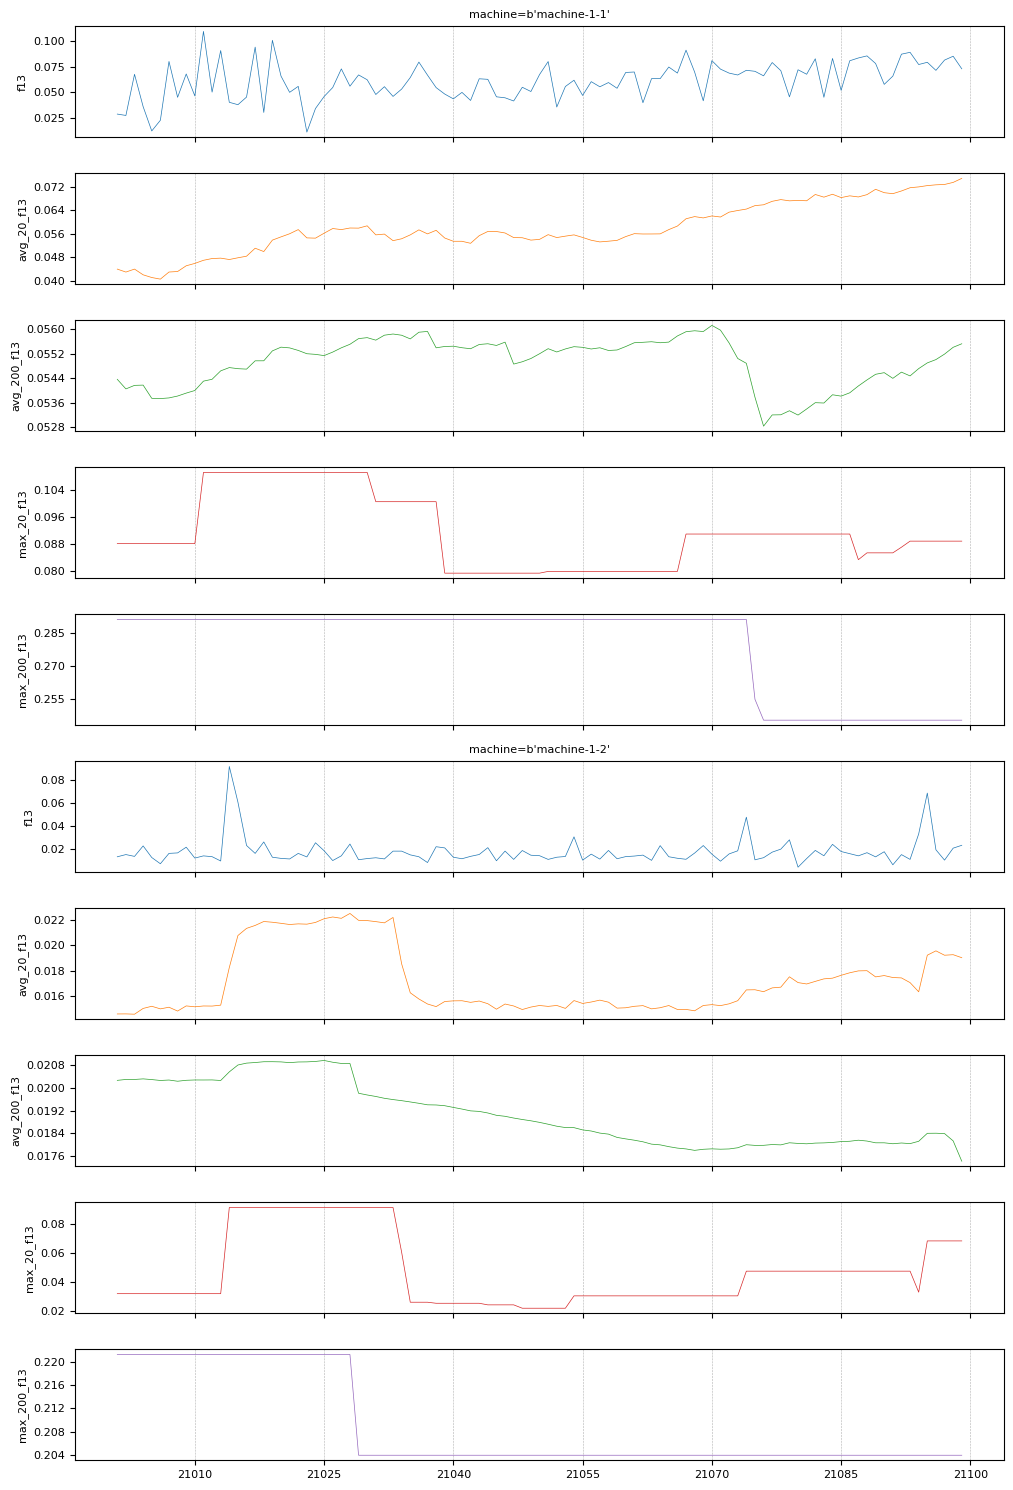

In [487]:
f13_stats = features[["f13", "avg_20_f13", "avg_200_f13", "max_20_f13", "max_200_f13"]]
timestamps = f13_stats.timestamps()
f13_stats = f13_stats.filter((timestamps > 21000) & (timestamps < 21100))
f13_stats.plot(max_num_plots=10)

Last train timestamp: 18955
Number of samples in train set: 56868
Number of positive (anomalous) samples in train set: 2702
Number of samples in test set: 18999
Number of positive (anomalous) samples in test set: 1704


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    3.8s remaining:   15.4s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    4.2s finished


[1 1 1 ... 0 0 0]
Results:
                raw features  lagged features  moving statistics
train_accuracy      0.648161         0.647772           0.690902
test_accuracy       0.565389         0.562307           0.671344
train_roc_auc       0.846675         0.868658           0.904850
test_roc_auc        0.904260         0.909366           0.947874
Train and test labels and predictions


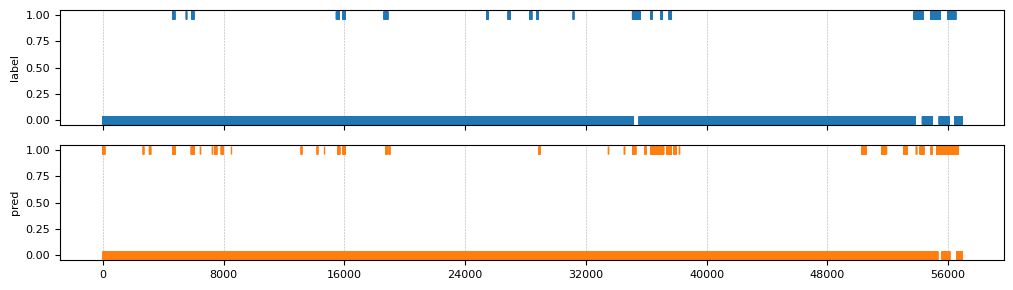

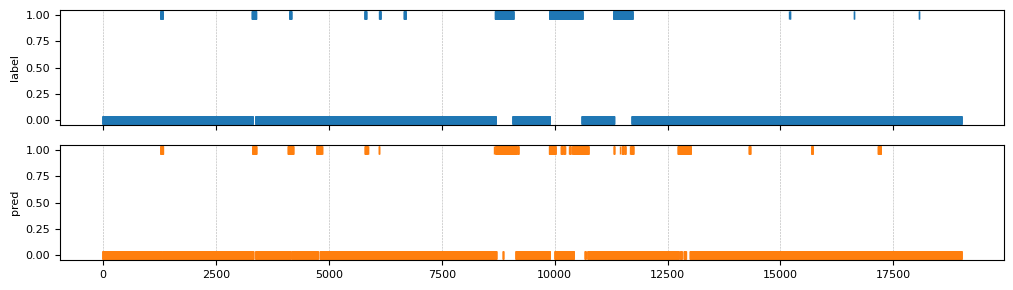

In [488]:
X_train, y_train, X_test, y_test = make_datasets(features, labels)
model = train(X_train)
evaluate(model, X_train, y_train, X_test, y_test, "moving statistics")

That's quite an improvement!

## Wrapping up

In this notebook we learned how to perform feature engineering and visualization using Temporian, applying it to a real-world anomaly detection use case.

There's some further work that could be done in this problem! Here's some ideas:
- Train a larger model! Training a larger model, on a larger dataset, would most likely yield improved results. As an example, try increasing the number of estimators in the IsolationForest to 1000 and re-run the experiments!
- Use the dataset's [unlabeled train data](https://github.com/NetManAIOps/OmniAnomaly/tree/master/ServerMachineDataset/train) to train the model in this unsupervised manner, and then use the data we used here to test it.
- Keep adding new features! As we demonstrated, a very simple model can go a long way if the correct features are provided to it. This is where Temporian shines - check out the full list of operators in the [API Reference](https://temporian.readthedocs.io/en/stable/reference/#operators) for some inspiration!